In [163]:
from sklearn.datasets import load_files
import matplotlib.pyplot as plt

In [164]:
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV 
from sklearn.pipeline import make_pipeline

In [165]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy 
import nltk
from sklearn.decomposition import LatentDirichletAllocation as LDA

# NLP on IMDb 
- IMDb: Internet Movie Database
- Task: Classification of Positive and Negative Reviews

## Import Data
- The dataset is available at http://ai.stanford.edu/~amaas/data/sentiment/.
- data will be imported as a bunch object
- there are 25000 reviews in each of the training and test sets (TOTAL: 50000)
- Each 25000 has 12500 psoitive and 12500 negative review

In [166]:
bunch_train = load_files('aclImdb_v1/aclImdb/train/')
bunch_test  = load_files('aclImdb_v1/aclImdb/test/')

### Data

In [5]:
type(bunch_train)

sklearn.utils.Bunch

In [6]:
bunch_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [7]:
bunch_train.data[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [8]:
bunch_train.data[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

__Byte Object__
- sequence of bytes  
- in machine readible form internally

In [9]:
type(bunch_train.data[1])

bytes

### target
- 1: positive
- 0: negative

In [10]:
bunch_train.target[:2]

array([1, 0])

In [11]:
Counter(bunch_train.target)

Counter({1: 12500, 0: 12500})

In [12]:
Counter(bunch_test.target)

Counter({1: 12500, 0: 12500})

### train, test 

In [167]:
X_train, y_train = bunch_train.data, bunch_train.target
X_test , y_test  = bunch_test.data , bunch_test.target

In [168]:
N = 1_000
X_train = [review.replace(b"<br />",b"")  for review in X_train][:N]
X_test = [review.replace(b"<br />",b"")  for review in X_test][:N]
y_train = y_train[:N]
y_test = y_test[:N]

In [19]:
import numpy as np
np.bincount(y_train)

array([498, 502], dtype=int64)

In [20]:
np.bincount(y_test)

array([498, 502], dtype=int64)

## Data Cleaning

In [21]:
review = X_train[0]
review

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. Flawed but honest with a terrible honesty."

In [22]:
review.replace(b'<br />', b' ')

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. Flawed but honest with a terrible honesty."

In [169]:
X_train = [review.replace(b'<br />', b' ')  for review in X_train]
X_test = [review.replace(b'<br />', b' ')  for review in X_test]

## Bag of Words

In [24]:
vect = CountVectorizer()
vect.fit(X_train)
X_train_bag = vect.transform(X_train)

In [25]:
X_train_bag.shape

(1000, 18134)

In [24]:
vect.get_feature_names_out()[:20]

array(['00', '000', '007', '01', '06', '07', '08', '10', '100', '1000',
       '1000lb', '100mph', '101', '104', '105', '10quality', '10s',
       '10star', '10th', '11'], dtype=object)

In [25]:
vect.get_feature_names_out()[-20:]

array(['zipper', 'zivagho', 'zizek', 'zoe', 'zombi', 'zombie', 'zombies',
       'zombified', 'zone', 'zoo', 'zoology', 'zoom', 'zooming', 'zorak',
       'zorrilla', 'zorro', 'zubeidaa', 'zuzz', 'zzzzz', 'ánd'],
      dtype=object)

In [27]:
vect.get_feature_names_out()[9_000:9_020]

array(['kirshner', 'kirsten', 'kiss', 'kissed', 'kisses', 'kissing',
       'kitbag', 'kitchen', 'kitschy', 'kitted', 'kitty', 'klane',
       'klaus', 'klaveno', 'klaw', 'klaymation', 'klemperer', 'klimt',
       'kline', 'klingon'], dtype=object)

In [27]:
vect = CountVectorizer(min_df=5)
vect.fit(X_train)
X_train_bag = vect.transform(X_train)
X_train_bag.shape

(1000, 3662)

In [31]:
vect = CountVectorizer(max_df=3)
vect.fit(X_train)
X_train_bag = vect.transform(X_train)
X_train_bag.shape

(1000, 13591)

In [32]:
vect = CountVectorizer(stop_words='english')
vect.fit(X_train)
X_train_bag = vect.transform(X_train)
X_train_bag.shape

(1000, 17838)

In [33]:
X_train_bag.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Logistic Regression

## Cross Validation

In [34]:
vect = CountVectorizer()
vect.fit(X_train)
X_train_bag = vect.transform(X_train)
X_train_bag.shape

(1000, 18134)

In [35]:
X_train_bag[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [36]:
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_bag, y_train, cv=5)
scores

array([0.745, 0.78 , 0.785, 0.82 , 0.815])

In [37]:
scores.mean()

0.7889999999999999

## Cross Validation (min_df)

In [38]:
vect = CountVectorizer(min_df=5)
vect.fit(X_train)
X_train_bag = vect.transform(X_train)
X_train_bag.shape

(1000, 3662)

In [40]:
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_bag, y_train, cv=5)
scores

array([0.725, 0.76 , 0.785, 0.82 , 0.805])

In [41]:
scores.mean()

0.779

## Grid Search

In [65]:
vect = CountVectorizer(min_df=5)
vect.fit(X_train)
X_train_bag = vect.transform(X_train)
X_test_bag = vect.transform(X_test)
X_train_bag.shape

(1000, 3662)

In [55]:
param_grid = {'C':[ 0.01, 0.1, 1,10,100]}

In [56]:
gs = GridSearchCV(LogisticRegression(max_iter=10_000), param_grid, cv=3)
gs.fit(X_train_bag, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [57]:
gs.score(X_train_bag, y_train)

0.997

In [58]:
gs.score(X_test_bag, y_test)

0.784

In [59]:
gs.best_params_

{'C': 0.1}

In [60]:
gs.best_estimator_.coef_

array([[-0.01236032, -0.11540994, -0.00566475, ..., -0.01734724,
         0.05292583, -0.0785146 ]])

In [61]:
gs.best_estimator_.coef_.shape

(1, 3662)

In [50]:
gs.best_estimator_.coef_.argmax()

1429

In [51]:
vect.get_feature_names_out()[gs.best_estimator_.coef_.argmax()]

'great'

In [52]:
gs.best_estimator_.coef_[0,gs.best_estimator_.coef_.argmax()]

0.5628885293483696

In [53]:
vect.get_feature_names_out()[gs.best_estimator_.coef_.argmin()]

'bad'

In [54]:
gs.best_estimator_.coef_[0,gs.best_estimator_.coef_.argmin()]

-0.7317529942898512

In [64]:
coef = gs.best_estimator_.coef_
coef[:10]

array([[-0.01236032, -0.11540994, -0.00566475, ..., -0.01734724,
         0.05292583, -0.0785146 ]])

In [66]:
f_names = vect.get_feature_names_out()
f_names[:10]

array(['000', '10', '100', '11', '12', '14', '15', '17', '19', '1930s'],
      dtype=object)

In [85]:
coef.argsort()

array([[ 292, 3627,  285, ..., 2348, 1059, 1429]], dtype=int64)

In [86]:
f_names[coef.argsort()]

array([['bad', 'worst', 'awful', ..., 'perfect', 'enjoy', 'great']],
      dtype=object)

In [88]:
coef[0,coef.argsort()]

array([[-0.73175299, -0.47677322, -0.43355829, ...,  0.37207137,
         0.39921872,  0.56288853]])

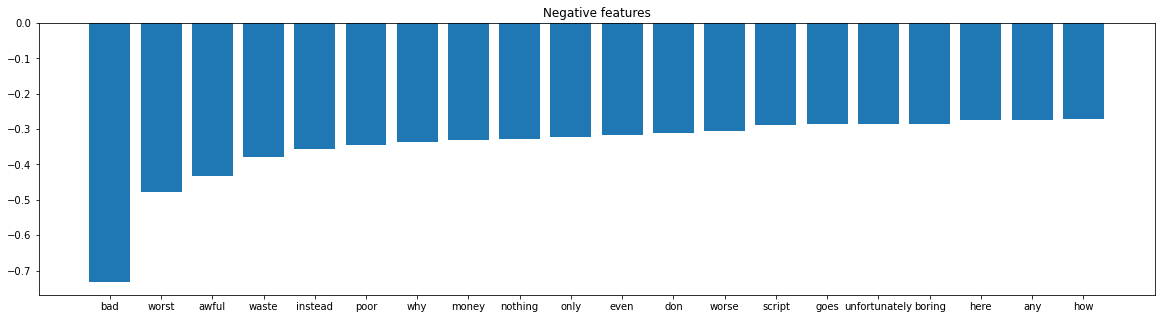

In [98]:
N = 20
plt.figure(figsize=(20,5))
plt.title('Negative features')
plt.bar( f_names[coef.argsort()][0,:N], coef[0,coef.argsort()][0,:N] );

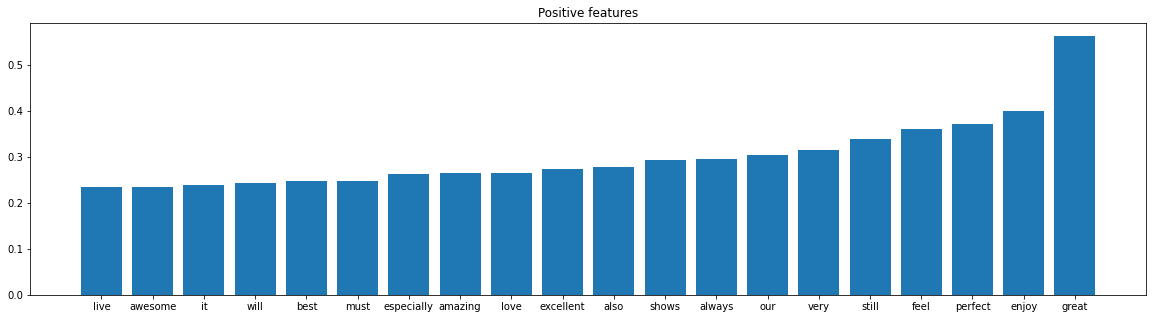

In [99]:
N = 20
plt.figure(figsize=(20,5))
plt.title('Positive features')
plt.bar( f_names[coef.argsort()][0,-N:], coef[0,coef.argsort()][0,-N:] );

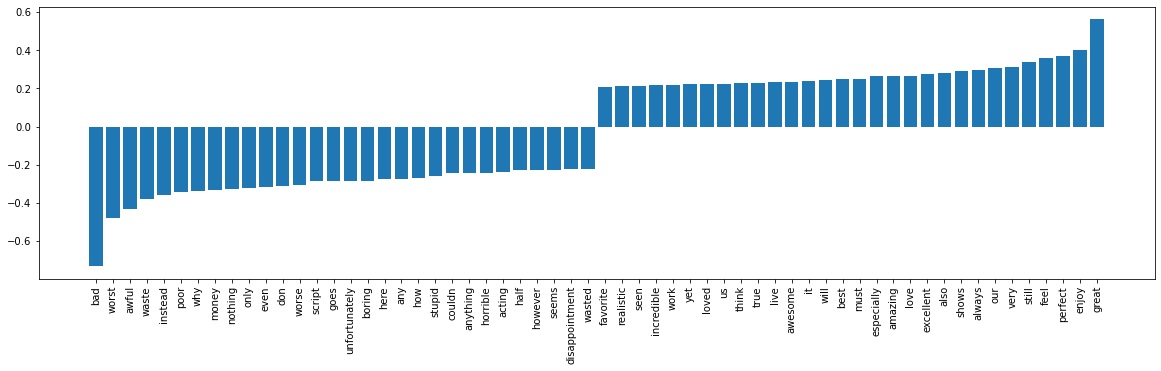

In [109]:
N = 30
features = np.hstack( [f_names[coef.argsort()][0,:N], f_names[coef.argsort()][0,-N:]])
coefficients = np.hstack([coef[0,coef.argsort()][0,:N],coef[0,coef.argsort()][0,-N:]])

plt.figure(figsize=(20,5))
plt.bar(features, coefficients)
plt.xticks(rotation=90);

## RandomizedSearch

In [110]:
param_grid = {'C':[ 0.01, 0.1, 1, 10]}

In [111]:
rs = RandomizedSearchCV(LogisticRegression(max_iter=10_000), param_grid, n_iter=2, cv=3)
rs.fit(X_train_bag, y_train)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=10000), n_iter=2,
                   param_distributions={'C': [0.01, 0.1, 1, 10]})

In [112]:
rs.score(X_train_bag, y_train)

0.997

In [113]:
rs.score(X_test_bag, y_test)

0.784

In [114]:
rs.cv_results_

{'mean_fit_time': array([0.10552303, 0.18339904]),
 'std_fit_time': array([0.01762016, 0.02806275]),
 'mean_score_time': array([0.00047453, 0.00068299]),
 'std_score_time': array([0.00040902, 0.00022284]),
 'param_C': masked_array(data=[0.1, 1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1}, {'C': 1}],
 'split0_test_score': array([0.76347305, 0.76347305]),
 'split1_test_score': array([0.8048048 , 0.81381381]),
 'split2_test_score': array([0.7957958 , 0.77777778]),
 'mean_test_score': array([0.78802455, 0.78502155]),
 'std_test_score': array([0.01774585, 0.02118021]),
 'rank_test_score': array([1, 2])}

In [115]:
rs.best_params_

{'C': 0.1}

# tfidf

In [116]:
vect_tf = TfidfVectorizer(min_df=10).fit(X_train)
X_train_tf = vect_tf.transform(X_train)
X_test_tf = vect_tf.transform(X_test)
X_train_tf.shape

(1000, 1912)

In [117]:
param_grid = {'C':[ 0.01, 0.1, 1,10]}

In [118]:
gs = GridSearchCV(LogisticRegression(max_iter=10_000), param_grid, cv=3)
gs.fit(X_train_tf, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.01, 0.1, 1, 10]})

In [119]:
gs.score(X_train_tf, y_train)

1.0

In [120]:
gs.score(X_test_tf, y_test)

0.799

In [121]:
gs.best_params_

{'C': 10}

# ngrams

In [122]:
vect_n = CountVectorizer(ngram_range=(1,4))
vect_n.fit(X_train)
X_train_n = vect_n.transform(X_train)
print(X_train_n.shape)
vect_n.get_feature_names_out()[:20]

(1000, 537701)


array(['00', '00 but', '00 but it', '00 but it sworth', '00 rental',
       '00 rental fee', '00 rental fee you', '00 replacement',
       '00 replacement fee', '00 replacement fee you', '000', '000 but',
       '000 but instead', '000 but instead of', '000 if', '000 if not',
       '000 if not considerably', '000 in', '000 in compensation',
       '000 in compensation throughout'], dtype=object)

In [123]:
param_grid = {'logisticregression__C':[ 0.1, 1,10]}
pipe = make_pipeline( CountVectorizer(ngram_range=(2,2)), LogisticRegression(max_iter=10_000) )
gs = GridSearchCV(pipe, param_grid, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(ngram_range=(2, 2))),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logisticregression__C': [0.1, 1, 10]})

In [124]:
gs.score(X_train, y_train)

1.0

In [125]:
gs.score(X_test, y_test)

0.757

In [126]:
gs.best_params_

{'logisticregression__C': 10}

In [127]:
gs.best_estimator_.steps[1][1].coef_

array([[ 0.01976837, -0.02070961, -0.02070961, ...,  0.013511  ,
        -0.00850473, -0.01201836]])

# Lemmanization

In [132]:
nlp = spacy.load('en_core_web_sm')

In [133]:
def lemma_tokenizer(review):
    return [token.lemma_ for token in nlp(review)]

In [134]:
lemma_tokenizer('go went going goes')

['go', 'go', 'go', 'go']

In [145]:
vect_lemma = CountVectorizer(tokenizer=lemma_tokenizer, min_df=3)
vect_lemma.fit(X_train)

CountVectorizer(min_df=3,
                tokenizer=<function lemma_tokenizer at 0x000002A234B8FC80>)

In [146]:
vect_lemma.get_feature_names_out()

array(['!', '"', '"the', ..., '\x85', '\x85 ', '\x96'], dtype=object)

In [147]:
vect_lemma.get_feature_names_out()[-30:]

array(['yard', 'yash', 'yawn', 'yeah', 'year', 'yearn', 'yell', 'yellow',
       'yes', 'yesterday', 'yet', 'yoko', 'york', 'yorker', 'you',
       'young', 'your', 'yourself', 'youth', 'zero', 'zeta', 'zoe',
       'zombie', 'zone', 'zoom', '{', '}', '\x85', '\x85 ', '\x96'],
      dtype=object)

In [151]:
len(vect_lemma.get_feature_names_out())

4985

In [148]:
X_train_lemma = vect_lemma.transform(X_train)

In [149]:
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_lemma, y_train, cv=5)
scores

array([0.745, 0.75 , 0.77 , 0.81 , 0.81 ])

In [150]:
scores.mean()

0.777

# Stemming

In [152]:
stemmer = nltk.stem.PorterStemmer()

In [153]:
def stem_tokenizer(review):
    return [ stemmer.stem(token.norm_.lower()) for token in nlp(review)]

In [154]:
stem_tokenizer('go went going goes')

['go', 'went', 'go', 'goe']

In [156]:
vect_stem = CountVectorizer(tokenizer=stem_tokenizer, min_df=10)
vect_stem.fit(X_train)

CountVectorizer(min_df=10,
                tokenizer=<function stem_tokenizer at 0x000002A2387D7C80>)

In [157]:
vect_stem.get_feature_names_out()

array(['!', '"', '$', ..., 'zombi', '\x85', '\x96'], dtype=object)

In [158]:
vect_stem.get_feature_names_out()[-30:]

array(['wood', 'word', 'work', 'world', 'wors', 'worst', 'worth',
       'worthi', 'would', 'wow', 'write', 'writer', 'written', 'wrong',
       'wrote', 'ye', 'yeah', 'year', 'yet', 'york', 'you', 'young',
       'younger', 'your', 'yourself', 'youth', 'zero', 'zombi', '\x85',
       '\x96'], dtype=object)

In [159]:
len(vect_stem.get_feature_names_out())

1847

In [160]:
X_train_stem = vect_stem.transform(X_train)

In [161]:
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_stem, y_train, cv=5)
scores

array([0.75 , 0.785, 0.765, 0.795, 0.785])

In [162]:
scores.mean()

0.776

# LDA

In [192]:
vect = CountVectorizer(max_features = 10_000, max_df=0.15)
X = vect.fit_transform(X_train)

In [193]:
f_names = vect.get_feature_names_out()
f_names

array(['00', '000', '10', ..., 'zorro', 'zubeidaa', 'zuzz'], dtype=object)

In [194]:
f_names.shape

(10000,)

In [195]:
X.shape

(1000, 10000)

In [196]:
lda = LDA(n_components=10, random_state=0)

In [197]:
lda.fit(X)

LatentDirichletAllocation(random_state=0)

In [198]:
lda.components_.shape

(10, 10000)

In [199]:
topics = lda.components_
topics.shape

(10, 10000)

In [200]:
max(topics[0]), min(topics[0])

(25.094281175409325, 0.10000000000234621)

In [201]:
sorted_top0 = np.argsort(topics[0])
sorted_top0

array([5577, 2586, 9986, ..., 1741, 9942,    2], dtype=int64)

In [202]:
sorted_top0[-10:]

array([7009,  410, 8794, 4586, 4433,  921, 7902, 1741, 9942,    2],
      dtype=int64)

In [203]:
f_names[sorted_top0[-10:]]

array(['re', 'am', 'thought', 'john', 'interesting', 'between', 'show',
       'comedy', 'young', '10'], dtype=object)

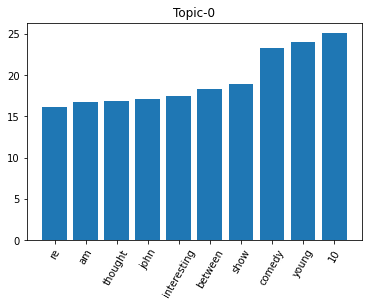

In [204]:
plt.title('Topic-0')
plt.bar(f_names[sorted_top0[-10:]], topics[0][sorted_top0[-10:]] )
plt.xticks(rotation=60);

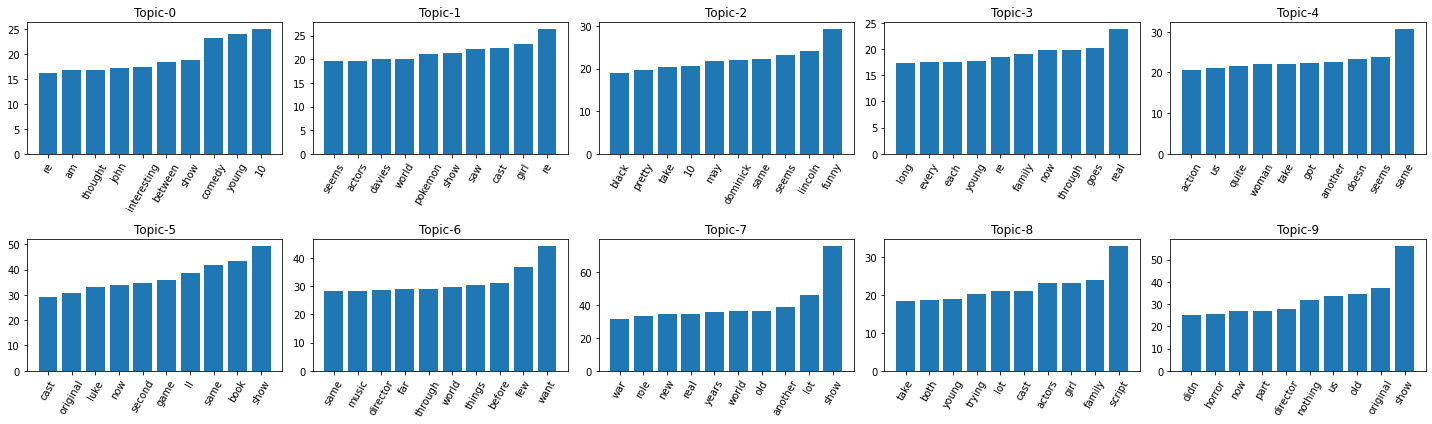

In [210]:
plt.figure(figsize=(20,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(f'Topic-{i}')
    sorted_top = np.argsort(topics[i])
    plt.bar(f_names[sorted_top[-10:]], topics[i][sorted_top[-10:]] )
    plt.xticks(rotation=60)
plt.tight_layout();

In [212]:
for i in range(10):
    sorted_top = np.argsort(topics[i])
    print(f'Topic-{i}: {f_names[sorted_top[-8:]]}')

Topic-0: ['thought' 'john' 'interesting' 'between' 'show' 'comedy' 'young' '10']
Topic-1: ['davies' 'world' 'pokemon' 'show' 'saw' 'cast' 'girl' 're']
Topic-2: ['take' '10' 'may' 'dominick' 'same' 'seems' 'lincoln' 'funny']
Topic-3: ['each' 'young' 're' 'family' 'now' 'through' 'goes' 'real']
Topic-4: ['quite' 'woman' 'take' 'got' 'another' 'doesn' 'seems' 'same']
Topic-5: ['luke' 'now' 'second' 'game' 'll' 'same' 'book' 'show']
Topic-6: ['director' 'far' 'through' 'world' 'things' 'before' 'few' 'want']
Topic-7: ['new' 'real' 'years' 'world' 'old' 'another' 'lot' 'show']
Topic-8: ['young' 'trying' 'lot' 'cast' 'actors' 'girl' 'family' 'script']
Topic-9: ['now' 'part' 'director' 'nothing' 'us' 'old' 'original' 'show']


In [215]:
lda_doc = lda.transform(X)
lda_doc.shape

(1000, 10)

In [216]:
lda_doc[0]

array([0.00175469, 0.00175465, 0.00175481, 0.00175481, 0.00175483,
       0.98420709, 0.00175481, 0.00175485, 0.00175469, 0.00175477])

In [217]:
[f'T-{i}' for i in range(10)]

['T-0', 'T-1', 'T-2', 'T-3', 'T-4', 'T-5', 'T-6', 'T-7', 'T-8', 'T-9']

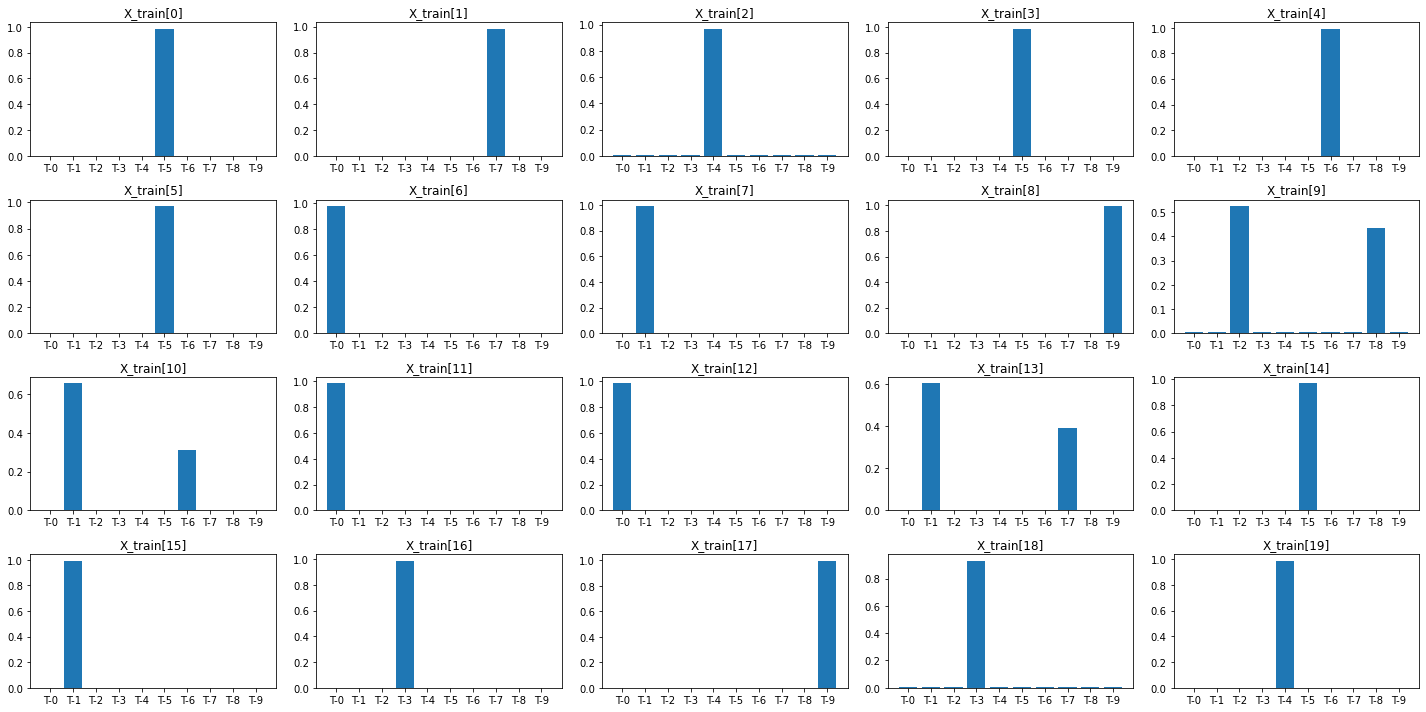

In [222]:
plt.figure(figsize=(20,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title(f'X_train[{i}]')
    plt.bar([f'T-{i}' for i in range(10)], lda_doc[i])
plt.tight_layout();

In [223]:
X_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. Flawed but honest with a terrible honesty."

# Appendix

## replace()

In [70]:
name = 'Michael Jordan'
name.replace('J', 'T')

'Michael Tordan'

In [71]:
name = 'Michael Jordan'
name.replace('r', ' ')

'Michael Jo dan'

In [72]:
name

'Michael Jordan'

In [73]:
name = name.replace('J', 'T')
name

'Michael Tordan'

## argsort()

In [79]:
myarray = np.array([10, 2, 6, 1, 8])

In [80]:
myarray.argmax() # index of the largest value

0

In [81]:
myarray.argmin() # index of the min value

3

In [82]:
myarray.argsort() # index values from smallest to largest

array([3, 1, 2, 4, 0], dtype=int64)

In [83]:
myarray.sort()

In [84]:
myarray

array([ 1,  2,  6,  8, 10])

## array dim

In [94]:
myarray = np.array( [ ['a', 'b', 'c', 'd']  ]  )

In [97]:
myarray[0, :3]

array(['a', 'b', 'c'], dtype='<U1')